# Part One: Data Exploration

The dataset we will study for this assignment contains information about health insurance costs for individuals with no dependents (children) in the United States. The information contained in the data is:

Age of primary beneficiary

Gender of primary beneficiary (only female, male recorded)

Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

Whether the beneficiary smokes

The beneficiary’s residential area in the US, northeast, southeast, southwest, northwest.

Individual medical costs billed by health insurance

You can find this data at: https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotnine as p9

## 1. Read in the dataset, and display some summaries of the data.


In [47]:
insurance = pd.read_csv("https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1")
insurance.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692


In [48]:
insurance.describe()

,age,bmi,charges
count,431.000000,431.000000,431.000000
mean,37.960557,30.768898,12297.098118
std,16.363909,6.111362,11876.527128
min,18.000000,15.960000,1131.506600
25%,22.000000,26.357500,2710.444575
50%,34.000000,30.590000,9866.304850
75%,55.000000,35.272500,14510.872600
max,64.000000,49.060000,55135.402090


## 2. Fix any concerns you have about the data.

In [49]:
# Custom ColumnTransformer with optional MinMax scaling
# Select categorical columns for encoding and numerical columns for scaling
ct = ColumnTransformer([
  ("dummify",
  OneHotEncoder(sparse_output = False, handle_unknown = "ignore"),
  make_column_selector(dtype_include=object)),

        ("scale_features", 
         StandardScaler(), 

         # Scales numerical features
         make_column_selector(dtype_include=np.number))  
    ],
    # Keeps any other columns as-is
    remainder="passthrough"  
)

## 3. Make up to three plots comparing the response variable (charges) to one of the predictor variables. Briefly discuss each plot.

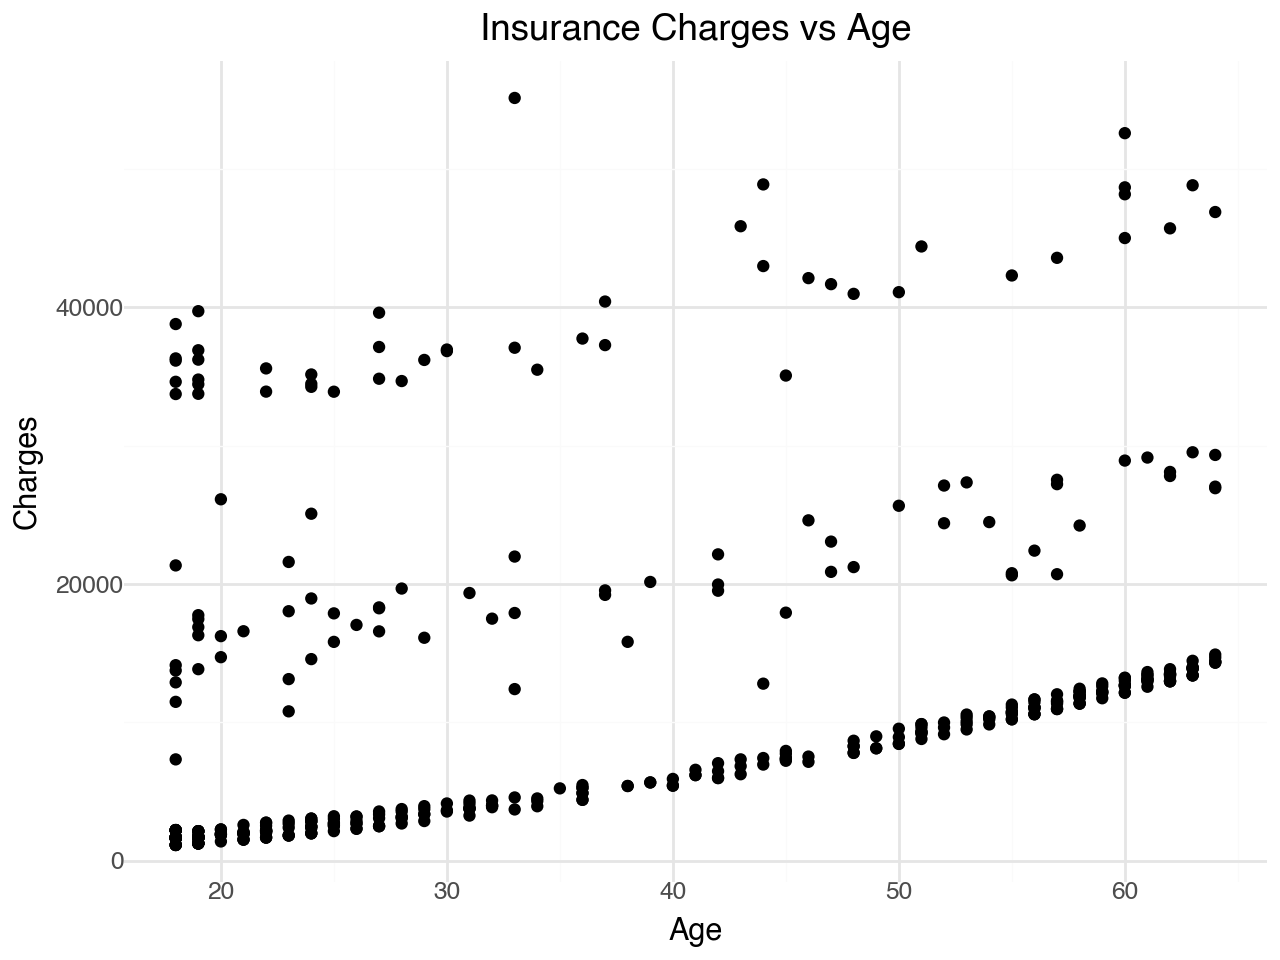

In [50]:
# Scatterplot of Insurance Charges Ages
(
    p9.ggplot(insurance, p9.aes(x = 'age', y = 'charges')) 
    + p9.geom_point() 
    + p9.labs(title = "Insurance Charges vs Age", x = "Age", y = "Charges") 
    + p9.theme_minimal()
)

There is an upward trend in this graph, which means that insurance costs increases as age increases. However, there is a wide spread so there may be other factors.

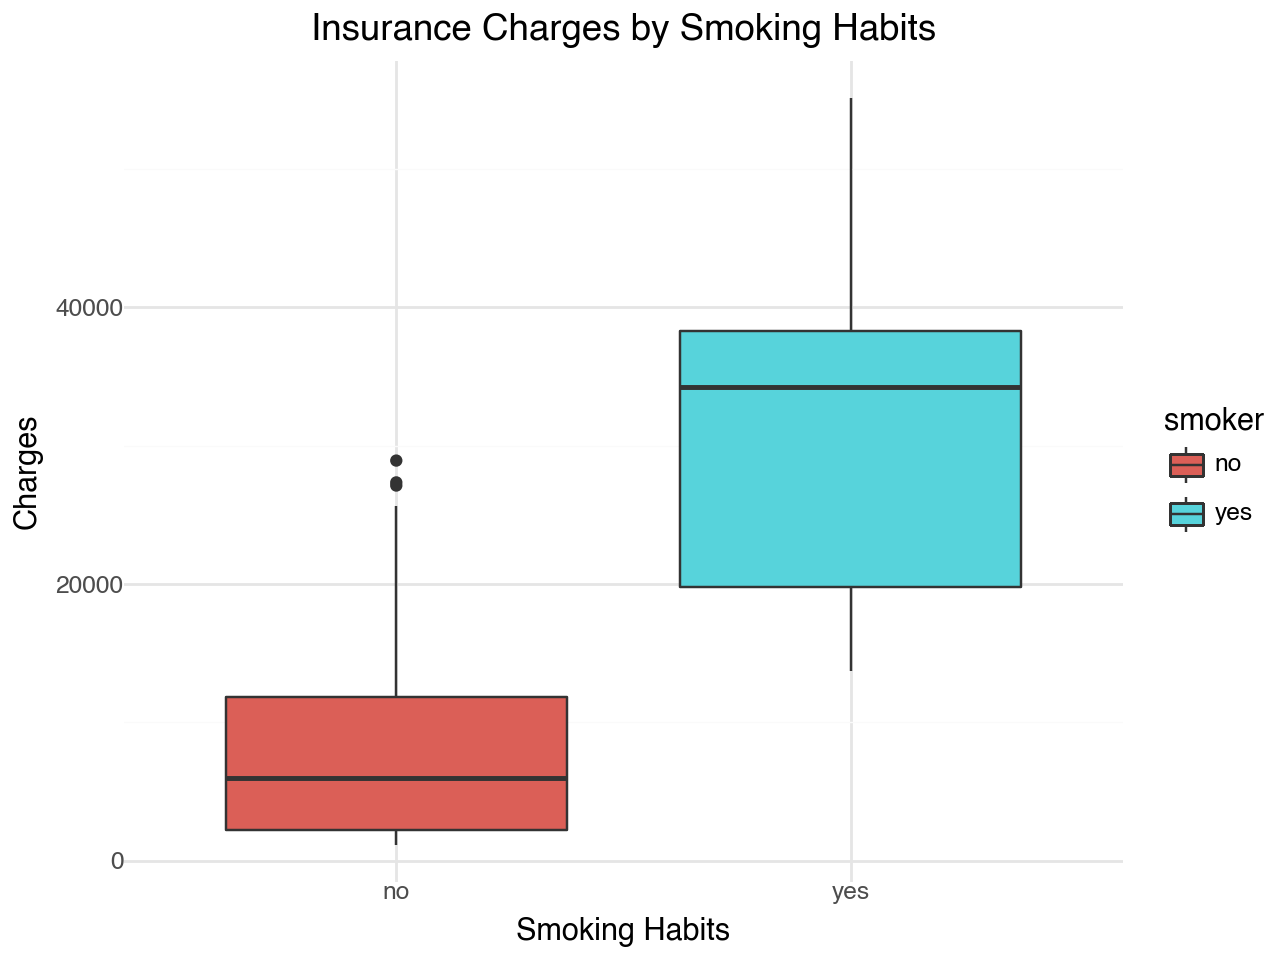

In [51]:
# Boxplot of Insurance Charges by Smoking Habits
(
    p9.ggplot(insurance, p9.aes(x = 'smoker', y = 'charges', fill = 'smoker')) 
    + p9.geom_boxplot() 
    + p9.labs(title = "Insurance Charges by Smoking Habits", x = "Smoking Habits", y = "Charges") 
    + p9.theme_minimal()
)

This boxplot highlights that the median insurance cost is significantly higher for smokers compared to nonsmokers. 

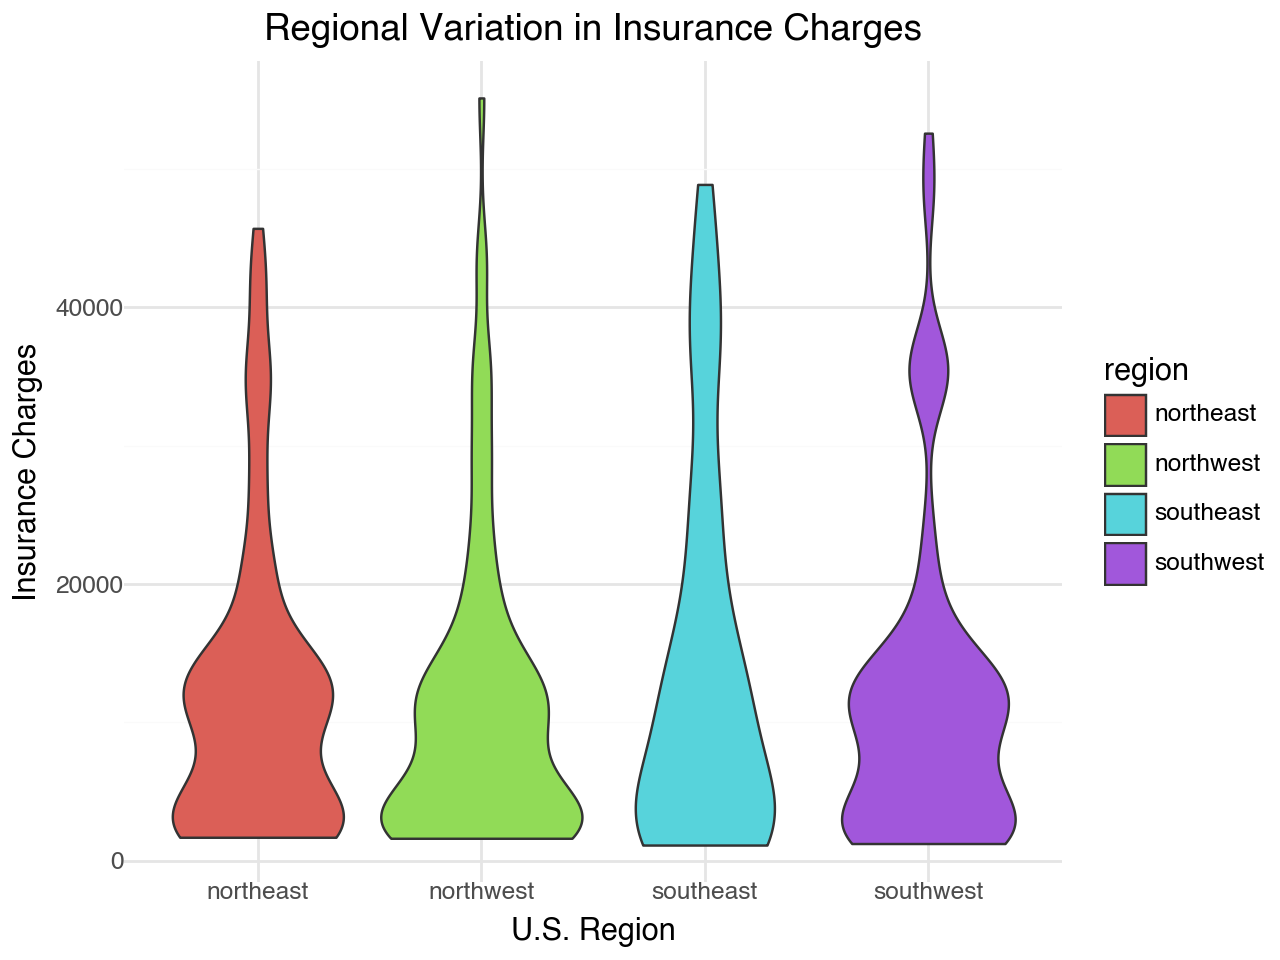

In [52]:
# Violin plot of Insurance Charges by Region
(
    p9.ggplot(insurance, p9.aes(x = 'region', y = 'charges', fill = 'region')) 
    + p9.geom_violin() 
    + p9.labs(title = "Regional Variation in Insurance Charges", x = "U.S. Region", y = "Insurance Charges") 
    + p9.theme_minimal()
)

This highlights that while all U.S regions have similar ranges in insurance charges, there are slight variations in the distribution. This suggest regional differences in healthcare costs or access.

# Part Two: Simple Linear Models

## 1. Construct a simple linear model to predict the insurance charges from the beneficiary’s age. Discuss the model fit, and interpret the coefficient estimates.

In [53]:
# Define predictors and target
X = insurance[['age']]
y = insurance['charges']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create and fit model in one step, predict in another
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred1 = lr.fit(X_train, y_train).predict(X_test)

# Retrieve the coefficient
lr.coef_[0]

211.69155768095112

In [54]:
# Calculate model performance metrics
mse_1 = mean_squared_error(y_test, lr_pred1)
r2_1 = r2_score(y_test, lr_pred1)

print("MSE of Model 1:", mse_1)
print("R^2 of Model 1:", r2_1)

MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628
MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628


For every 1 year increase in age, the individual's insurance costs increases by $211.69 on average. This model's fit is not best, which is indicated by the low R^2 of 13.87%. This means that age by itself does not explain the variability in insurance cost

## 2. Make a model that also incorporates the variable sex. Report your results.

In [55]:
# Define predictors and target
X = insurance[['age', 'sex']]
y = insurance['charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a pipeline with the column transformer and linear regression model
pipeline = Pipeline([
    ("preprocessor", ct),
    ("regressor", LinearRegression())
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
lr_pred2 = pipeline.predict(X_test)

# Retrieve the coefficient and intercept for interpretation
# To access the coefficients from the pipeline, use named_steps to get the regressor
coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

# Display the results
print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")

Intercept: 12137.00976920266
Coefficients: [-465.74070594  465.74070594 3463.23932548]
Intercept: 12137.00976920266
Coefficients: [-465.74070594  465.74070594 3463.23932548]


## 3. Now make a model that does not include sex, but does include smoker. Report your results.

In [56]:
# Define predictors and target
X = insurance[['age', 'smoker']]
y = insurance['charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a pipeline with the column transformer and linear regression model
pipeline = Pipeline([
    ("preprocessor", ct),
    ("regressor", LinearRegression())
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
lr_pred3 = pipeline.predict(X_test)

# Retrieve the coefficient and intercept for interpretation
# To access the coefficients from the pipeline, use named_steps to get the regressor
coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

# Display the results
print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")

Intercept: 8.004111406341608e+16
Coefficients: [-8.00411141e+16 -8.00411141e+16  4.30300000e+03]
Intercept: 8.004111406341608e+16
Coefficients: [-8.00411141e+16 -8.00411141e+16  4.30300000e+03]


## 4. Which model (Q2 or Q3) do you think better fits the data? Justify your answer by calculating the MSE for each model, and also by comparing R-squared values.

In [57]:
# Finding MSE Values
mse_2 = mean_squared_error(y_test, lr_pred2)
mse_3 = mean_squared_error(y_test, lr_pred3)

print("MSE of Model 2:", mse_2)
print("MSE of Model 3:", mse_3)
print()

# Finding R^2 Values

r2_2 = r2_score(y_test, lr_pred2)
r2_3 = r2_score(y_test, lr_pred3)

print("R^2 of Model 2:", r2_2)
print("R^2 of Model 3:", r2_3)

MSE of Model 2: 121104288.21589915
MSE of Model 3: 32096881.34384105

R^2 of Model 2: -0.1987828170773318
R^2 of Model 3: 0.6822805335499659
MSE of Model 2: 121104288.21589915
MSE of Model 3: 32096881.34384105

R^2 of Model 2: -0.1987828170773318
R^2 of Model 3: 0.6822805335499659


The model from question 3 is a much better fit compared to the model from question 2 becauase the MSE of 3 is much smaller and the R^2 value is much higher at 73.87% compared to -18.22% in Model 2.

# Part Three: Multiple Linear Models
Now let’s consider including multiple quantitative predictors.

## 1. Fit a model that uses age and bmi as predictors. (Do not include an interaction term, age*bmi, between these two.) Report your results. How does the MSE compare to the model in Part Two Q1? How does the R-squared compare?

In [58]:
# Define predictors and target
X = insurance[['age', 'bmi']]
y = insurance['charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Create a pipeline with the column transformer and linear regression model
pipeline = Pipeline([
    ("preprocessor", ct),
    ("regressor", LinearRegression())
])

# Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
lr_pred4 = pipeline.predict(X_test)

# Retrieve the coefficient and intercept for interpretation
# To access the coefficients from the pipeline, use named_steps to get the regressor
coefficients = pipeline.named_steps['regressor'].coef_
intercept = pipeline.named_steps['regressor'].intercept_

# Display the results
print(f"Intercept: {intercept}")
print(f"Coefficients: {coefficients}")

Intercept: 12944.468285167182
Coefficients: [3672.40818247 2131.01099953]
Intercept: 12944.468285167182
Coefficients: [3672.40818247 2131.01099953]


In [59]:
# Calculate model performance metrics
mse_4 = mean_squared_error(y_test, lr_pred4)
r2_4 = r2_score(y_test, lr_pred4)

print("MSE of Model 4:", mse_4)
print("R^2 of Model 4:", r2_4)

MSE of Model 4: 83176412.56118344
R^2 of Model 4: 0.02165662619769959
MSE of Model 4: 83176412.56118344
R^2 of Model 4: 0.02165662619769959


In [60]:
print("MSE of Model 1:", mse_1)
print("R^2 of Model 1:", r2_1)

MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628
MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628


Adding bmi slightly improves the fit because it has a slightly lower MSE and slightly higher R^2. 

## 2. Perhaps the relationships are not linear. Fit a model that uses age and age^2 as predictors. How do the MSE and R-squared compare to the model in P2 Q1?

In [61]:
# Define predictors and target, including 'age' and 'smoker'
X = insurance[['age', 'smoker']]
y = insurance['charges']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Set up PolynomialFeatures to add quadratic term for 'age' (degree 2)
quad_reg = PolynomialFeatures(degree=2, include_bias=False)

# Pipeline for preprocessing, polynomial feature generation, and linear regression modeling
quad_pipeline = Pipeline([
    ('preprocessor', ct),  # Preprocess categorical and numeric features
    ('polynomial_features', quad_reg),  # Add age^2 as an additional feature
    ('linear_regression', LinearRegression())  # Linear regression model
])

# Fit the pipeline on the training data
quad_fit = quad_pipeline.fit(X_train, y_train)

# Predict on the test set
quad_preds = quad_fit.predict(X_test)

# Outputting coefficients from the linear regression model
print("Coefficients:", quad_fit.named_steps['linear_regression'].coef_)
print("Intercept:", quad_fit.named_steps['linear_regression'].intercept_)

# Calculate MSE and R^2 for comparison
mse_5 = mean_squared_error(y_test, quad_preds)
r2_5 = r2_score(y_test, quad_preds)

# Print results
print("MSE of Model 5:", mse_5)
print("R^2 of Model 5:", r2_5)


Coefficients: [-5938.07557384  5938.07557384  2491.72361761 -5938.07557384     0.
  1580.5764456   5938.07557384   911.14717201   414.29463775]
Intercept: 18994.956363600497
MSE of Model 5: 27465271.999570943
R^2 of Model 5: 0.8057860400237651
Coefficients: [-5938.07557384  5938.07557384  2491.72361761 -5938.07557384     0.
  1580.5764456   5938.07557384   911.14717201   414.29463775]
Intercept: 18994.956363600497
MSE of Model 5: 27465271.999570943
R^2 of Model 5: 0.8057860400237651


In [62]:
print("MSE of Model 1:", mse_1)
print("R^2 of Model 1:", r2_1)

MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628
MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628


Model 5 with age^2 is a better fit because it has a significantly lower MSE and a significantly higher R^2.

## 3. Fit a polynomial model of degree 4. How do the MSE and R-squared compare to the model in P2 Q1?

In [63]:
# Define predictors and target
X = insurance[['age']]
y = insurance['charges']

# Create polynomial features up to degree 4
poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and calculate metrics
lr_pred6 = lr.predict(X_test)
mse_6 = mean_squared_error(y_test, lr_pred6)
r2_6 = r2_score(y_test, lr_pred6)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("MSE of Model 6:", mse_6)
print("R^2 of Model 6:", r2_6)

Coefficients: [-6.35413346e+03  2.75406912e+02 -4.79001188e+00  2.94777099e-02]
Intercept: 58861.29437810214
MSE of Model 6: 119880218.40966572
R^2 of Model 6: 0.15229632750329858
Coefficients: [-6.35413346e+03  2.75406912e+02 -4.79001188e+00  2.94777099e-02]
Intercept: 58861.29437810214
MSE of Model 6: 119880218.40966572
R^2 of Model 6: 0.15229632750329858


Model 6 is a slightly better fit because it has a slightly lower MSE and slightly higher R^2.

## 4. Fit a polynomial model of degree 12. How do the MSE and R-squared compare to the model in P2 Q1?

In [64]:
# Define predictors and target
X = insurance[['age']]
y = insurance['charges']

# Create polynomial features up to degree 12
poly = PolynomialFeatures(degree=12, include_bias=False)
X_poly = poly.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and calculate metrics
lr_pred7 = lr.predict(X_test)
mse_7 = mean_squared_error(y_test, lr_pred7)
r2_7 = r2_score(y_test, lr_pred7)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
print("MSE of Model 7:", mse_7)
print("R^2 of Model 7:", r2_7)

Coefficients: [ 4.69368191e-10 -2.23280298e-05  3.23929172e-07  5.44095571e-06
  6.49748717e-05  4.34257090e-04 -4.84509082e-05  2.23575192e-06
 -5.44386046e-08  7.35598662e-10 -5.22330175e-12  1.52224221e-14]
Intercept: 6676.09992005678
MSE of Model 7: 122497088.1250618
R^2 of Model 7: 0.1337917727267468
Coefficients: [ 4.69368191e-10 -2.23280298e-05  3.23929172e-07  5.44095571e-06
  6.49748717e-05  4.34257090e-04 -4.84509082e-05  2.23575192e-06
 -5.44386046e-08  7.35598662e-10 -5.22330175e-12  1.52224221e-14]
Intercept: 6676.09992005678
MSE of Model 7: 122497088.1250618
R^2 of Model 7: 0.1337917727267468


Model 1 is a better fit than Model 7 because Model 7 has a slightly higher MSE and slightly lower R^2.

## 5. According to the MSE and R-squared, which is the best model? Do you agree that this is indeed the “best” model? Why or why not?

In [65]:
print("MSE of Model 1:", mse_1)
print("R^2 of Model 1:", r2_1)

print("MSE of Model 2:", mse_2)
print("R^2 of Model 2:", r2_2)

print("MSE of Model 3:", mse_3)
print("R^2 of Model 3:", r2_3)

print("MSE of Model 4:", mse_4)
print("R^2 of Model 4:", r2_4)

print("MSE of Model 5:", mse_5)
print("R^2 of Model 5:", r2_5)

print("MSE of Model 6:", mse_6)
print("R^2 of Model 6:", r2_6)

print("MSE of Model 7:", mse_7)
print("R^2 of Model 7:", r2_7)

MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628
MSE of Model 2: 121104288.21589915
R^2 of Model 2: -0.1987828170773318
MSE of Model 3: 32096881.34384105
R^2 of Model 3: 0.6822805335499659
MSE of Model 4: 83176412.56118344
R^2 of Model 4: 0.02165662619769959
MSE of Model 5: 27465271.999570943
R^2 of Model 5: 0.8057860400237651
MSE of Model 6: 119880218.40966572
R^2 of Model 6: 0.15229632750329858
MSE of Model 7: 122497088.1250618
R^2 of Model 7: 0.1337917727267468
MSE of Model 1: 121801716.15974969
R^2 of Model 1: 0.138708925669628
MSE of Model 2: 121104288.21589915
R^2 of Model 2: -0.1987828170773318
MSE of Model 3: 32096881.34384105
R^2 of Model 3: 0.6822805335499659
MSE of Model 4: 83176412.56118344
R^2 of Model 4: 0.02165662619769959
MSE of Model 5: 27465271.999570943
R^2 of Model 5: 0.8057860400237651
MSE of Model 6: 119880218.40966572
R^2 of Model 6: 0.15229632750329858
MSE of Model 7: 122497088.1250618
R^2 of Model 7: 0.1337917727267468


Based on MSE and R^2 Model 5 with age and smoker is the best model. I do not completely agree with this because there may be other variables such as region that has an impact on insurance cost.

## 6. Plot the predictions from your model in Q4 as a line plot on top of the scatterplot of your original data.

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names


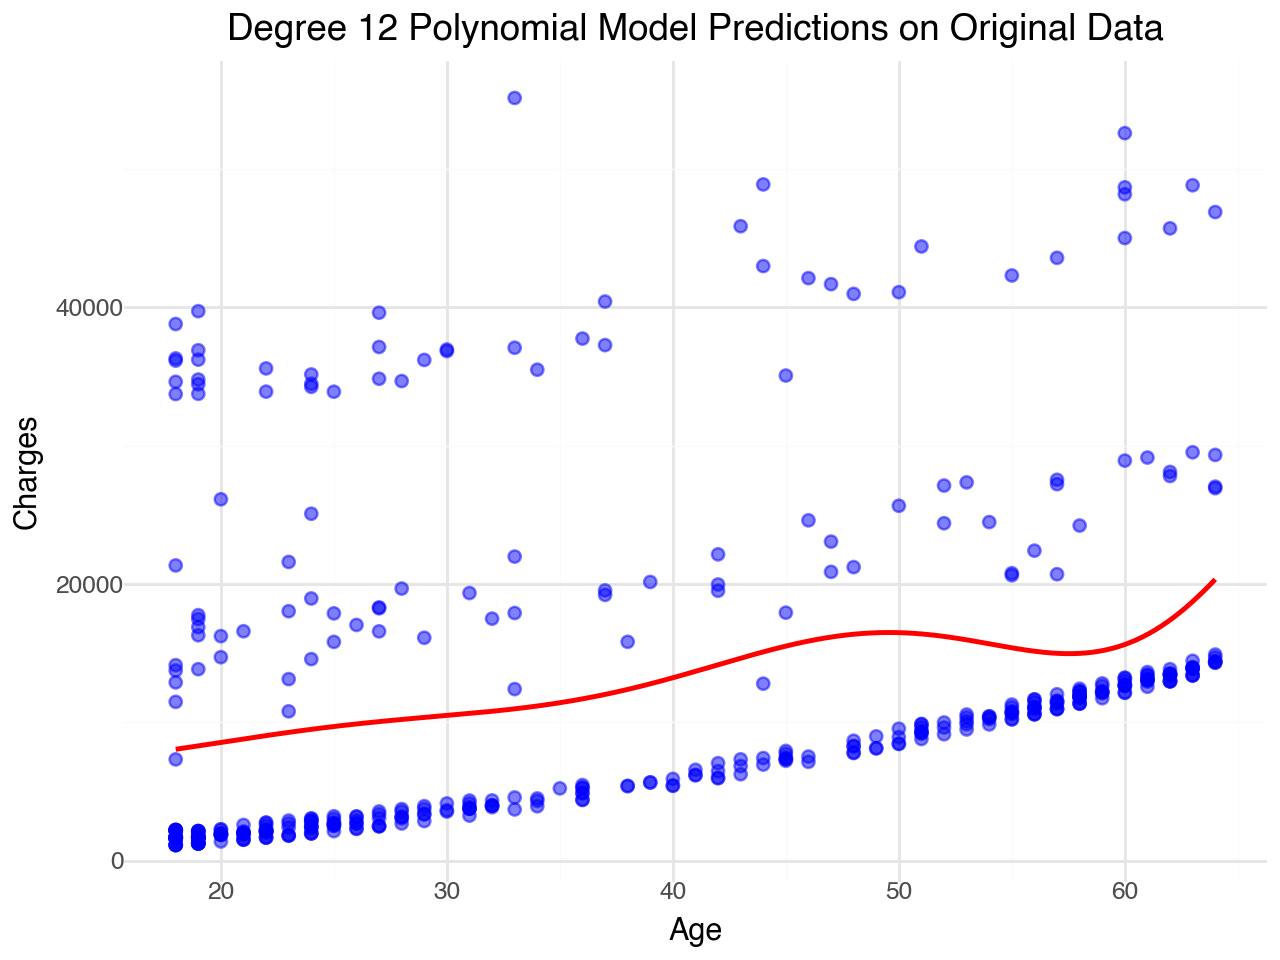

In [66]:
# Define predictors and target
X = insurance[['age']]
y = insurance['charges']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=42)

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Generate predictions over a smooth range of ages for the line plot
age_range = np.linspace(X['age'].min(), X['age'].max(), 500).reshape(-1, 1)
age_range_poly = poly.transform(age_range)
y_range_pred = lr.predict(age_range_poly)

# Prepare DataFrames for plotting
plot_data = pd.DataFrame({'age': X['age'], 'charges': y})
pred_line = pd.DataFrame({'age': age_range.flatten(), 'preds': y_range_pred})

# Plot 
(
    p9.ggplot(insurance, p9.aes(x="age", y="charges")) 
    + p9.geom_point(color="blue", alpha=0.5, size=2) 
    + p9.geom_line(pred_line, p9.aes(x="age", y="preds"), color="red", size=1) 
    +  p9.labs(
        x="Age",
        y="Charges",
        title="Degree 12 Polynomial Model Predictions on Original Data"
    ) 
    + p9.theme_minimal() 
)


# Part Four: New data

Great news! We’ve managed to collect data about the insurance costs for a few more individuals. You can find the new dataset here: https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1

Consider the following possible models:

Only age as a predictor.

age and bmi as a predictor.

age, bmi, and smoker as predictors (no interaction terms)

age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)

age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

For each model, fit the model on the original data.

Then, use the fitted model to predict on the new data.

Report the MSE for each model’s new predictions. Based on this, which is the best model to use?

Make a plot showing the residuals of your final chosen model.

In [67]:
insurance2 = pd.read_csv("https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1")

In [68]:
# Only age
X_train = insurance[["age"]]
y_train = insurance["charges"]

X_test = insurance2[["age"]]
y_test = insurance2["charges"]

lr = LinearRegression()

lr_fit = lr.fit(X_train, y_train)

lr_pred8 = lr_fit.predict(X_test)

# Calculate MSE
mse_age = mean_squared_error(y_test, lr_pred8)

# Display the result
print("MSE for model with only Age as predictor:", mse_age)

MSE for model with only Age as predictor: 136077136.50195494
MSE for model with only Age as predictor: 136077136.50195494


In [69]:
# Age and BMI
X_train = insurance[["age", "bmi"]]
X_test = insurance2[["age", "bmi"]]

lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)


lr_pred9 = lr_fit.predict(X_test)


mse_age_bmi = mean_squared_error(y_test, lr_pred9)


print("MSE for model with Age and BMI as predictors:", mse_age_bmi)

MSE for model with Age and BMI as predictors: 132636406.1108129
MSE for model with Age and BMI as predictors: 132636406.1108129


In [70]:
# Age, bmi, and smoker as predictors (no interaction terms)
X_train = insurance[["age", "bmi", "smoker"]]
X_test = insurance2[["age", "bmi", "smoker"]]

# Creating Pipeline
lr_pipeline = Pipeline(
    [('Dummify', ct),
     ('OLS', lr)
     ]
)

# Fitting Pipeline
lr_fitted = lr_pipeline.fit(X_train, y_train)
lr_pred10 = lr_fitted.predict(X=X_test)

mse_age_bmi_smoker = mean_squared_error(y_test, lr_pred10)


print("MSE for model with Age, BMI, and Smoker as predictors:", mse_age_bmi_smoker)

MSE for model with Age, BMI, and Smoker as predictors: 35478718.57114998
MSE for model with Age, BMI, and Smoker as predictors: 35478718.57114998


In [71]:
# age, and bmi, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi):smoker)

# Creating Variables for Interactions
insurance_dummies = pd.get_dummies(insurance)
insurance2_dummies = pd.get_dummies(insurance2)

insurance_dummies['bmi*smoker'] = insurance_dummies['bmi'] * insurance_dummies['smoker_yes']
insurance_dummies['age*smoker'] = insurance_dummies['age'] * insurance_dummies['smoker_yes']

insurance2_dummies['bmi*smoker'] = insurance2_dummies['bmi'] * insurance2_dummies['smoker_yes']
insurance2_dummies['age*smoker'] = insurance2_dummies['age'] * insurance2_dummies['smoker_yes']

# Define X for training and testing sets
X_train = insurance_dummies[["age", "bmi", "bmi*smoker", "age*smoker"]]

X_test = insurance2_dummies[["age", "bmi", "bmi*smoker", "age*smoker"]]

# Initialize and fit the model
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)

# Predict on the test set
inter_preds = lr_fit.predict(X_test)

# Calculate MSE
mse_inter = mean_squared_error(y_test, inter_preds)
print("MSE for model with (age + bmi):smoker:", mse_inter)


MSE for model with (age + bmi):smoker:MSE for model with (age + bmi):smoker:

 24795908.412643354
 24795908.412643354


In [77]:
# age, bmi, and smokeras predictors, with both quantitative variables having an interaction term with smoker (i.e. the formula ~ (age + bmi)*smoker)

# Create dummy variables and interaction terms
insurance_dummies = pd.get_dummies(insurance)
insurance2_dummies = pd.get_dummies(insurance2)

insurance_dummies['bmi*smoker'] = insurance_dummies['bmi'] * insurance_dummies['smoker_yes']
insurance_dummies['age*smoker'] = insurance_dummies['age'] * insurance_dummies['smoker_yes']
insurance_dummies['age*bmi*smoker'] = insurance_dummies['age'] * insurance_dummies['bmi'] * insurance_dummies['smoker_yes']

insurance2_dummies['bmi*smoker'] = insurance2_dummies['bmi'] * insurance2_dummies['smoker_yes']
insurance2_dummies['age*smoker'] = insurance2_dummies['age'] * insurance2_dummies['smoker_yes']
insurance2_dummies['age*bmi*smoker'] = insurance2_dummies['age'] * insurance2_dummies['bmi'] * insurance2_dummies['smoker_yes']

# Define X and y for training and testing sets
X_train = insurance_dummies[["age", "bmi", "smoker_yes", "bmi*smoker", "age*smoker", "age*bmi*smoker"]]

X_test = insurance2_dummies[["age", "bmi", "smoker_yes", "bmi*smoker", "age*smoker", "age*bmi*smoker"]]

# Initialize and fit the model
lr = LinearRegression()
lr_fit = lr.fit(X_train, y_train)

# Predict on the test set
inter_preds = lr_fit.predict(X_test)

# Calculate MSE
mse_inter2 = mean_squared_error(y_test, inter_preds)
print("MSE for model with (age + bmi)*smoker:", mse_inter2)

MSE for model with (age + bmi)*smoker: 21662413.35541886
MSE for model with (age + bmi)*smoker: 21662413.35541886


Based on MSE the model with (age + bmi)*smoker is the best fit because it has the lowest MSE.

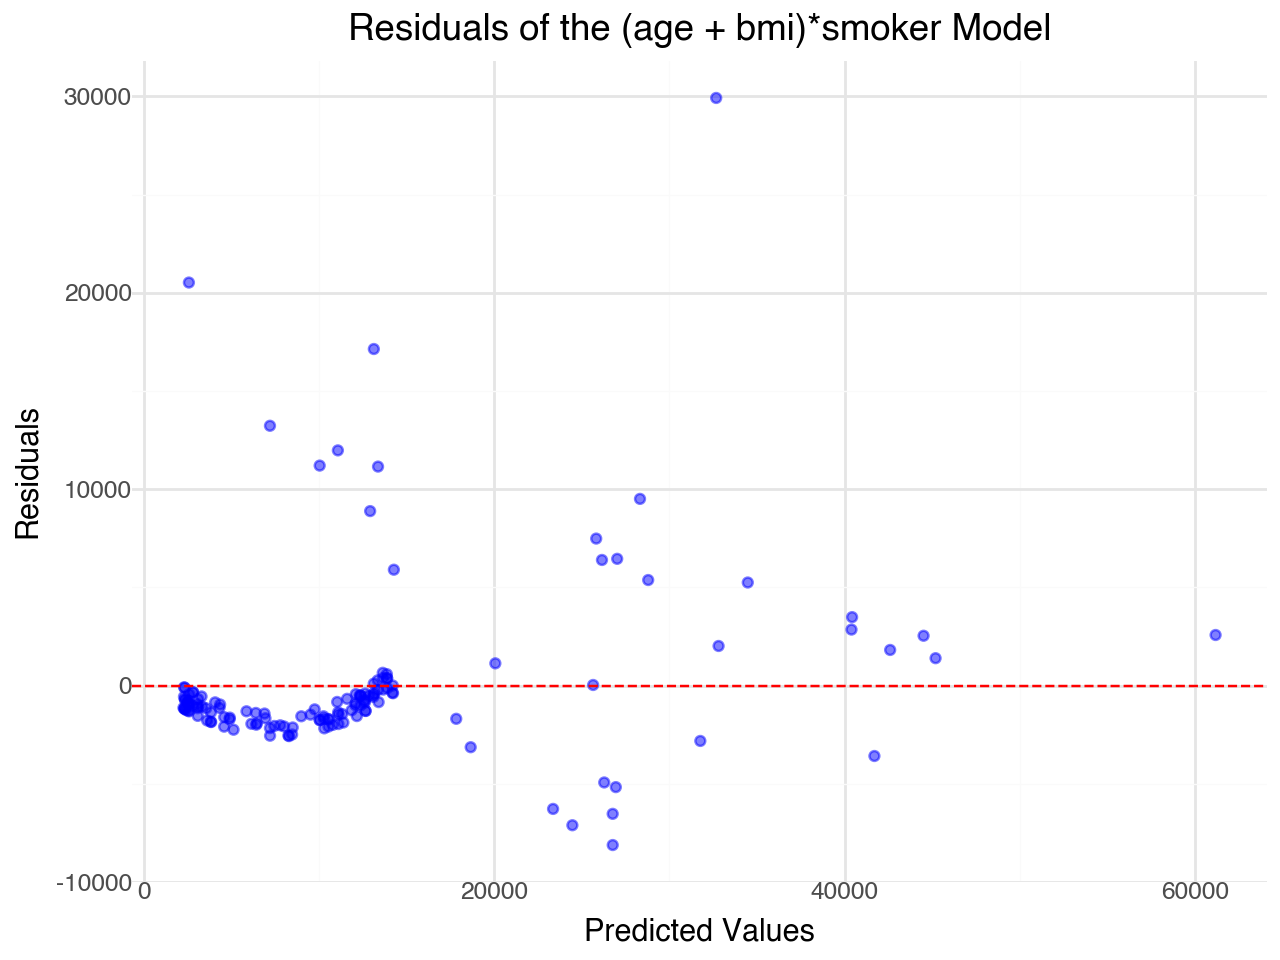

In [78]:
# Calculate residuals
residuals = y_test - inter_preds

# Create a DataFrame for plotting residuals
residuals_df = pd.DataFrame({
    'Predicted': inter_preds,
    'Residuals': residuals
})

# Plotting the residuals
(
    p9.ggplot(residuals_df, p9.aes(x='Predicted', y='Residuals')) 
    + p9.geom_point(alpha=0.5, color='blue') 
    + p9.geom_hline(yintercept=0, color='red', linetype='dashed') 
    + p9.labs(
        title='Residuals of the (age + bmi)*smoker Model',
        x='Predicted Values',
        y='Residuals'
    ) 
    + p9.theme_minimal()
)

# Part Five: Full Exploration
Using any variables in this dataset, and any polynomial of those variables, find the model that best predicts on the new data after being fit on the original data.

Make a plot showing the residuals of your final chosen model.

In [85]:
# Create dummy variables 
insurance_dummies = pd.get_dummies(insurance, columns=['sex', 'smoker', 'region'], drop_first=True)
insurance2_dummies = pd.get_dummies(insurance2, columns=['sex', 'smoker', 'region'], drop_first=True)

# Create interaction terms: age*smoker, bmi*smoker, and age*bmi*smoker
insurance_dummies['age*bmi'] = insurance_dummies['age'] * insurance_dummies['bmi']
insurance_dummies['bmi*smoker_yes'] = insurance_dummies['bmi'] * insurance_dummies['smoker_yes']
insurance_dummies['age*smoker_yes'] = insurance_dummies['age'] * insurance_dummies['smoker_yes']
insurance_dummies['age*bmi*smoker_yes'] = insurance_dummies['age'] * insurance_dummies['bmi'] * insurance_dummies['smoker_yes']

insurance2_dummies['age*bmi'] = insurance2_dummies['age'] * insurance2_dummies['bmi']
insurance2_dummies['bmi*smoker_yes'] = insurance2_dummies['bmi'] * insurance2_dummies['smoker_yes']
insurance2_dummies['age*smoker_yes'] = insurance2_dummies['age'] * insurance2_dummies['smoker_yes']
insurance2_dummies['age*bmi*smoker_yes'] = insurance2_dummies['age'] * insurance2_dummies['bmi'] * insurance2_dummies['smoker_yes']

# Define predictors and target for training and testing sets with the new interaction terms
X_train_interactions = insurance_dummies[["age", "bmi", "smoker_yes", "age*bmi", "bmi*smoker_yes", "age*smoker_yes", "age*bmi*smoker_yes"]]
X_test_interactions = insurance2_dummies[["age", "bmi", "smoker_yes", "age*bmi", "bmi*smoker_yes", "age*smoker_yes", "age*bmi*smoker_yes"]]

# Fit a linear regression model 
model_interactions = LinearRegression()
model_interactions.fit(X_train_interactions, y_train)

# Predict on the test set
inter_preds = model_interactions.predict(X_test_interactions)

# Calculate MSE
mse_best = mean_squared_error(y_test, inter_preds)
print("MSE of Model That Best Predicts on the New Data:", mse_best)

MSE of Model That Best Predicts on the New Data: 21649538.59707786
MSE of Model That Best Predicts on the New Data: 21649538.59707786


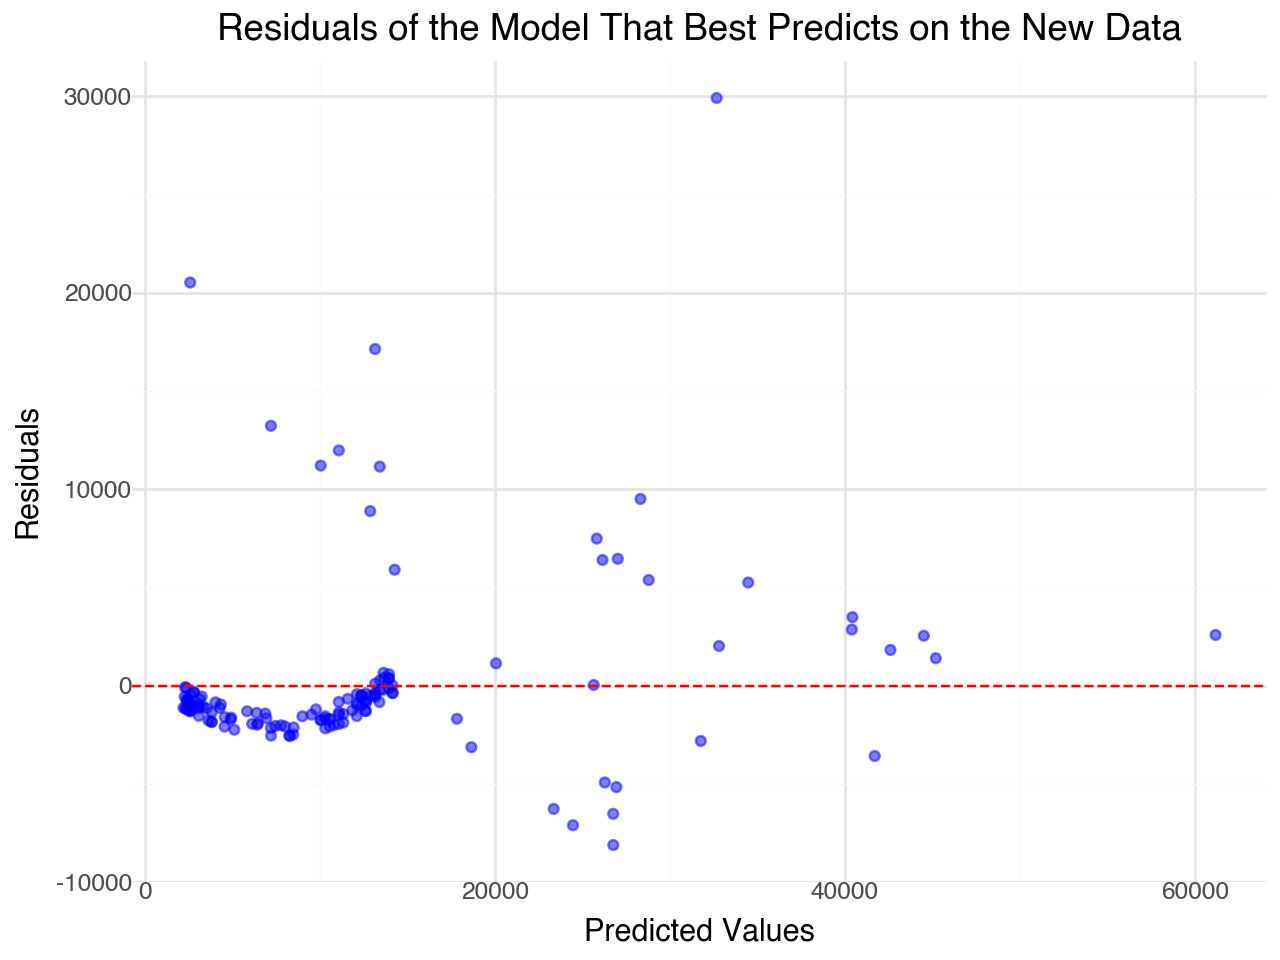

In [84]:
# Create a DataFrame for residuals plotting
residuals_df = pd.DataFrame({
    'Predicted': inter_preds,
    'Residuals': residuals
})

# Plotting the residuals
(
    p9.ggplot(residuals_df, p9.aes(x='Predicted', y='Residuals')) 
    + p9.geom_point(alpha=0.5, color='blue') 
    + p9.geom_hline(yintercept=0, color='red', linetype='dashed') 
    + p9.labs(
        title='Residuals of the Model That Best Predicts on the New Data',
        x='Predicted Values',
        y='Residuals'
    ) 
    + p9.theme_minimal()
)